<a href="https://colab.research.google.com/github/dkioroglou/programmers_salaries_2023/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/dkioroglou/programmers_salaries_2023/main/data/salaries_2023.csv")

In [11]:
df = df[[
      '[Fixed] Ποιος είναι ο ΕΤΗΣΙΟΣ ΚΑΘΑΡΟΣ μισθός σου σε €;',
      'Με ποιες γλώσσες προγραμματισμού δουλεύεις επαγγελματικά αυτή την περίοδο;',
      'Πόσα χρόνια δουλεύεις επαγγελματικά ως προγραμματιστής;',
      'Ποιό είναι το επίπεδο σπουδών σου;',
      'Φύλλο;',
      '[GROUP] Σε ποια πόλη δουλεύεις, Greece ή Abroad',
      'Τι μέγεθος είναι η εταιρεία που δουλεύεις;'
      ]]

df.columns = [
      'salary',
      'languages',
      'experience',
      'studies',
      'gender',
      'jobLocation',
      'companySize'
      ]

# Missing values distribution

In [12]:
df.isna().sum()

salary         0
languages      0
experience     0
studies        0
gender         2
jobLocation    0
companySize    0
dtype: int64

In [13]:
df['gender'].value_counts()

Άντρας               949
Γυναίκα               53
Προτιμώ να μην πω      1
Nuclear Sub            1
Name: gender, dtype: int64

In [14]:
mask = df.isna()['gender']
df[mask]

,salary,languages,experience,studies,gender,jobLocation,companySize
64,19600.0,"JavaScript, Ruby",7,Bachelor's,NaN,Ελλάδα,201 - 500
541,10100.0,"Java, JavaScript",1,Bachelor's,NaN,Ελλάδα,101 - 200


In [15]:
# Remove entries with missing or unspecified gender
df =  df.drop([64, 541, 68, 167])

# Distribution of salaries

In [16]:
df['salary'].describe()

count      1002.000000
mean      24117.334262
std       16305.507428
min          15.008000
25%       14820.000000
50%       20155.000000
75%       27595.000000
max      180000.000000
Name: salary, dtype: float64

<Axes: xlabel='salary', ylabel='Count'>

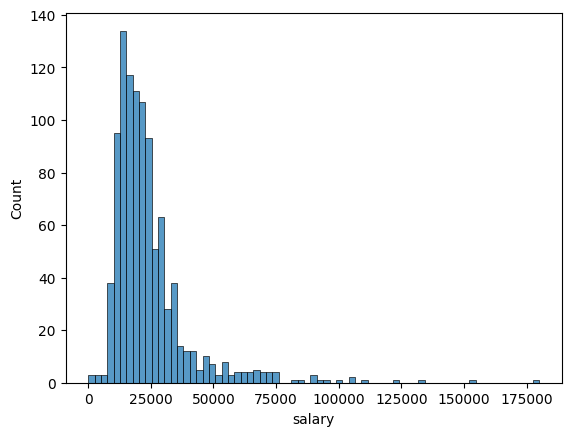

In [17]:
sns.histplot(df['salary'])

In [18]:
# Remove outliers
# Select data with salaries between the 10th and 90th percentiles of salaries
perc10th =  df['salary'].quantile(0.1)
perc90th = df['salary'].quantile(0.9)
df = df.query('salary >= @perc10th & salary <= @perc90th')

<Axes: xlabel='salary', ylabel='Count'>

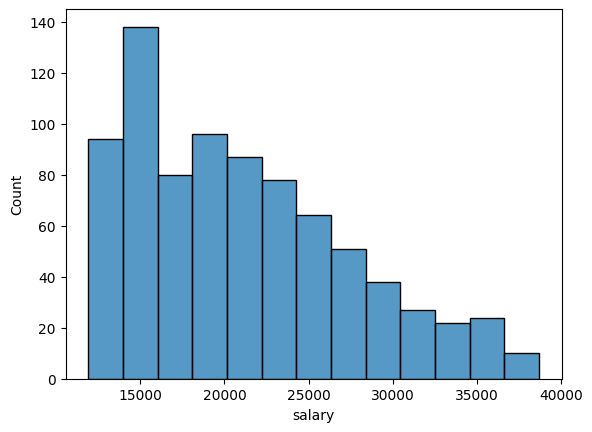

In [19]:
sns.histplot(df['salary'])

## <font color="#EB984E">General remark</font>

Salaries are not normally distributed. This makes things more difficult, but... that's life! To keep things simple, the salaries were not transformed and a simple OLS regression was performed on the data.




# Sample size after filtering

In [20]:
df.shape

(809, 7)

# Gender distribution after filtering

In [21]:
df['gender'].value_counts()

Άντρας     768
Γυναίκα     41
Name: gender, dtype: int64

## Feature engineering and recoding

In [22]:
df['languagesNumber'] = df['languages'].map(lambda x: len(x.split(",")) if ',' in x else 1)

In [23]:
df['languagesNumber'].value_counts()

1    435
2    263
3     83
4     18
5      7
6      3
Name: languagesNumber, dtype: int64

In [24]:
df['companySize'].value_counts()

501+         256
11 - 50      179
201 - 500    106
51 - 100      94
101 - 200     92
1 - 10        82
Name: companySize, dtype: int64

In [25]:
df['companySizeBinned'] = df['companySize'].map({
                                                '1 - 10':'small',
                                                '11 - 50': 'small',
                                                '51 - 100': 'small',
                                                '101 - 200': 'medium',
                                                '201 - 500': 'medium',
                                                '501+': 'large'
                                                })

In [26]:
df['companySizeBinned'].value_counts()

small     355
large     256
medium    198
Name: companySizeBinned, dtype: int64

In [27]:
df['companySizeBinnedRecoded'] = df['companySizeBinned'].map({"small":1, "medium":2, "large": 3})

In [28]:
df['genderRecoded'] = df['gender'].map({"Άντρας":1, "Γυναίκα":0})

In [29]:
df['jobLocationRecoded'] = df['jobLocation'].map({"Ελλάδα":1, "Εξωτερικό":0})

In [31]:
df['studies'].value_counts()

Bachelor's                        411
Master                            280
Λύκειο                             75
ΙΕΚ                                32
PhD                                 6
Χωρίς Δευτεροβάθμια Εκπαίδευση      5
Name: studies, dtype: int64

In [35]:
df['studiesRecoded'] = df['studies'].map({
    'Χωρίς Δευτεροβάθμια Εκπαίδευση':1,
    'Λύκειο': 2,
    'ΙΕΚ': 3,
    "Bachelor's": 4,
    'Master': 5,
    'PhD': 6
})

# Ordinary Least Square regression

In [36]:
X = df[['genderRecoded', 'studiesRecoded', 'experience', 'languagesNumber', 'companySizeBinnedRecoded', 'jobLocationRecoded']]
X.insert(0, 'intercept', 1)
y = df['salary']

In [37]:
model = sm.OLS(y, X).fit()

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     63.55
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           1.54e-64
Time:                        18:24:57   Log-Likelihood:                -8095.0
No. Observations:                 809   AIC:                         1.620e+04
Df Residuals:                     802   BIC:                         1.624e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                 2.171e+04   1533.956     14.154      0.000    1.87e+04    2.47e+04
genderRecoded              752.4278    865.808      0.869      0.385    -947.089    2451.945
studiesRecoded             216.9936    209.315      1.037      0.300    -193.876     627.863
experience                 713.9436     45.670     15.632      0.000     624.296     803.591
languagesNumber            -64.5090    223.852     -0.288      0.773    -503.913     374.895
companySizeBinnedRecoded  1027.1131    220.604      4.656      0.000     594.085    1460.142
jobLocationRecoded       -7664.1769    714.001    -10.734      0.000   -9065.707   -6262.646
==============================================================================
Omnibus:                       25.343   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.067
Skew:                          -0.014   Prob(JB):                     9.05e-14
Kurtosis:                       4.335   Cond. No.                         64.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

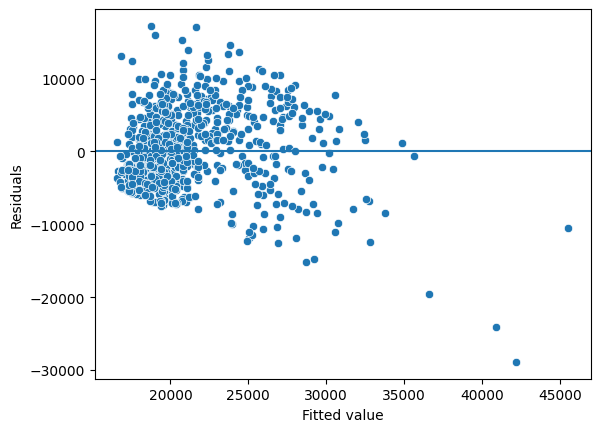

In [39]:
# Plot residuals
sns.scatterplot(
    x=model.get_prediction().summary_frame()['mean'],
    y=model.resid
    )
plt.axhline(y=0)
plt.xlabel("Fitted value")
plt.ylabel("Residuals")
plt.show()

## <font color="#EB984E">General remark</font>

With the six included features, the model explains only 32% of the observed variability associated with the salaries. It's not great, but represents a decent starting point.






# Results

In [52]:
modelParams = model.conf_int()
modelParams['mean'] = model.params
modelParams['pvals'] = model.pvalues
modelParams.columns = ['CI_low', 'CI_upper', 'mean', 'pvals']
modelParams['Significant'] = [True if x <= 0.05 else False for x in modelParams['pvals']]

In [53]:
modelParams

,CI_low,CI_upper,mean,pvals,Significant
intercept,18701.255250,24723.340168,21712.297709,9.175417e-41,True
genderRecoded,-947.089282,2451.944869,752.427793,3.850814e-01,False
studiesRecoded,-193.875564,627.862730,216.993583,3.001945e-01,False
experience,624.295744,803.591380,713.943562,2.774043e-48,True
languagesNumber,-503.913056,374.895003,-64.509026,7.732851e-01,False
companySizeBinnedRecoded,594.084581,1460.141653,1027.113117,3.773641e-06,True
jobLocationRecoded,-9065.707315,-6262.646460,-7664.176888,3.297919e-25,True


## <font color="#EB984E">General remark</font>

The coefficients for the features **gender**, **studies** and **number of languages** are not statistically significant. This means that these factors don't appear to have a significant effect on the salary. However, the non-significance could be due to small sample size.




# Predictions

In [64]:
def predictSalary(*args):
  """args = intercept, gender, studies, experience, languagesN, companySize, jobLocation"""
  mean = np.dot(modelParams['mean'], np.array(args))
  CIlow = np.dot(modelParams['CI_low'], np.array(args))
  CIupper = np.dot(modelParams['CI_upper'], np.array(args))
  return (mean, CIlow, CIupper)

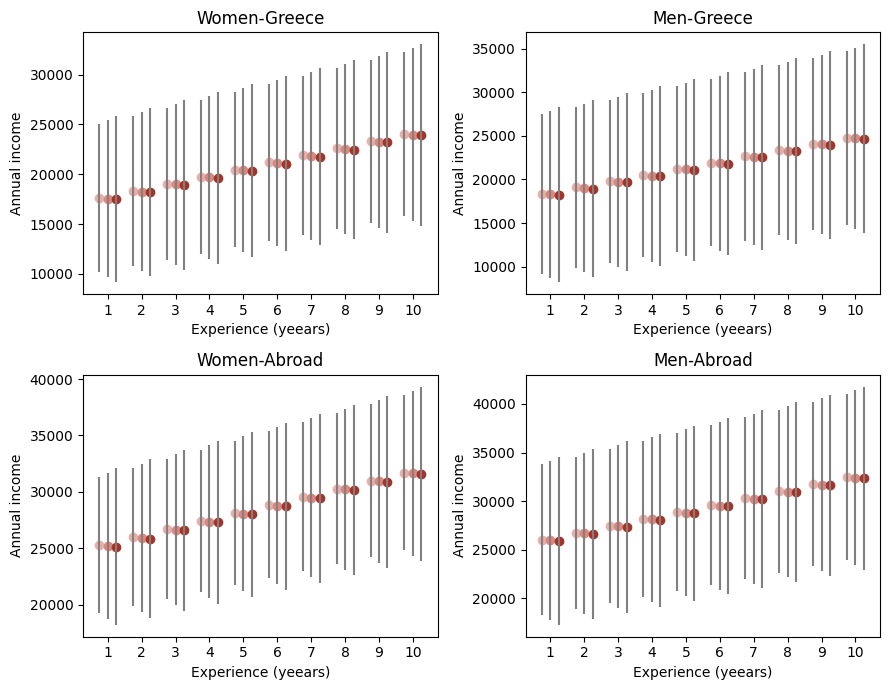

In [113]:
intercept = 1
typeStudies = 4 # Bachelor
sizeCompany = 2 # medium-sized
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,7))
for ax, gender, location, title in zip(
    axes.flatten().tolist(),
     [0, 1, 0, 1],
     [1, 1, 0, 0],
     ['Women-Greece', 'Men-Greece', 'Women-Abroad', 'Men-Abroad']):
  for years in range(1, 11):
    xVal = [years-0.25, years, years+0.25]
    colors = ['#E6B0AA', '#D98880', '#A93226']
    for langsN in range(1, 4):
      idx = langsN - 1
      mean, low, upper = predictSalary(intercept, gender, typeStudies, years, langsN, sizeCompany, location)
      ax.plot(xVal[idx] , mean, 'o', color=colors[idx])
      ax.vlines(x=xVal[idx], ymin=low, ymax=upper, color='gray')
      ax.set_xticks(np.arange(1, 11))
      ax.set_xlabel("Experience (yeears)")
      ax.set_ylabel("Annual income")
      ax.set_title(title)
plt.tight_layout()


## <font color="#EB984E">General remark</font>

In the figure above the predicted annual income is shown for a programmer that has obtained his Bachelor and wants to work in a medium-sized company (=100 up to 500 people). The annual salary is predicted based on the number of years of experience and number of languages (1=light-red, 2=red, 3=dark-red). Circles represent the mean and the vertical lines the possible range of the annual salary for a given number of years of experience and languages.

The unexpected part is that based on the data, for every additional language a programmer knows, his annual income is reduced by 64€ on average. Additionally, for this feature the annual gain on the income can range from -503€ (reduction) up to +374€ (increase). This great variability can be attributed to the differences in the negotiating capability of the programmers that participated in the survey and the type of language each programmer additionally knew. The latter has not been included in this model and adds a lot to the uncertainty of the predictions.

